In [1]:
from kalman_matrix import StateKalmanFilter
from scipy import poly1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Toy example: moving object

Imagine we have a moving object whose motion we are tracking with a camera/radar. The state of the object consists of its position and velocity. We know that we have the relationship $x_t = x_{t-1} + v_{t-1}\delta t - \frac{1}{2} a (\delta t)^2$, where $\delta t$ is the time (in seconds) elapsed between $t-1$ and $t$, and $a$ acceleration. Meanwhile, our camera/rader can tell us the position,velocity of the object every second, but we know from the manufacturer that the camera/radar accuracy, translated into the position,velocity of the object, implies variance in the position estimate of about 25 meters, variance in the velocity estimate of about 6m/sec.

In order to use a Kalman filter, we need to give it transition and observation matrices, transition and observation covariance matrices, and the initial state. The state of the system is (position, velocity), so it follows the transition matrix
$$ \left( \begin{array}{cc}
1 & \delta t \\
0 & 1 \end{array} \right) $$

with offset $(-(\delta t)^2 \cdot a/2, -\delta t\cdot a)$. The observation matrix just extracts the position coordinate, (1  0), since we are measuring position and also measuring velocity, then observation matrix is $[[1,0], [0,1]]$. For the inital state, let's feed our model something bogus like (4000, 280) and see how our system evolves.

Observations: 
Position(Pos) & Velocity(Vel):

| Pos (m)  | vel (m/s)|
|------|-----|
| 4000 | 280 |
| 4260 | 282 |
| 4550 | 284 |
| 4860 | 286 |
| 5100 | 290 |

Process Errors in Process covariance matrix
$\delta P_x$ =20m
$\delta P_{v_x}$=5m/sec

Observations Errors
$\delta X$ =25m
$\delta v_x$=6m/sec

Initials conditions:
$a_x$=2m/sec2
$\delta t$=1sec
$v_x$=280m/sec
$X$=4000m


In [2]:
a=np.array([4000,4260,4550,4860,5110])
b=np.array([280,282,285,286,290])
np.vstack((a,b)).T

array([[4000,  280],
       [4260,  282],
       [4550,  285],
       [4860,  286],
       [5110,  290]])

In [3]:
data=np.vstack((a,b)).T

In [4]:
# Initial or original state estimate
X0=data[0]
X0

array([4000,  280])

In [5]:
#transition matrices
dt=1
A=np.array([1,dt,0,1]).reshape(2,2)
A

array([[1, 1],
       [0, 1]])

In [6]:
#transition offsets
B = np.array([0.5*dt**2,1]) 
B

array([0.5, 1. ])

In [7]:
#observation matrices
C = np.array([1,0,0,1]).reshape(2,2)
C

array([[1, 0],
       [0, 1]])

In [8]:
#error in process estimates
dx=20
dvx=5
P=np.array([dx**2,dx*dvx,dx*dvx,dvx**2]).reshape(2,2)
P=np.diag(np.diag(P))
P

array([[400,   0],
       [  0,  25]])

In [9]:
data=data[1:]

In [10]:
data.shape

(4, 2)

In [11]:
#control input
ci=np.array([2])
ci

array([2])

In [12]:
#error in observation/measurements
R=np.array([625,0,0,36]).reshape(2,2)
R

array([[625,   0],
       [  0,  36]])

In [13]:
# Process noise covariance matrix #transition coveriance
Q = 0  

In [14]:
# Initialise the Kalman Filter 
from kalman_matrix import StateKalmanFilter
A = A  #transition matrix
C = C  # Measurement/observation matrix
B = B  # control input
Q = 0  # Process noise covariance matrix
R = R  # error in data measurement/observation
x = X0  # Initial or original state estimate
P = P  #error estimate, state covariance matrix
ci=np.array([2]) #control imput
current_pos=[]
current_vel=[]
predicted_pos=[]
predicted_vel=[]
kalman_filter = StateKalmanFilter(A, B, C, x, P, Q, R)
for data in data:
    kalman_filter.step(ci, data) #$ control_input, measurement
    print(kalman_filter.predicted_state_estimate)
    print(kalman_filter.predicted_prob_estimate)
    print(kalman_filter.kalman_gain)
    current_pos.append(kalman_filter.current_state()[0])
    current_vel.append(kalman_filter.current_state()[1])
    predicted_pos.append(kalman_filter.predicted_state_estimate[0])
    predicted_vel.append(kalman_filter.predicted_state_estimate[1])
    print(kalman_filter.current_state())
    #print(kalman_filter.current_prob_estimate)
    #print(kalman_filter.innovation)
    #print(kalman_filter.innovation_covariance)

[4281.  282.]
[[425  25]
 [ 25  25]]
[[0.4047619  1.        ]
 [1.         0.40983607]]
[4272.5  282. ]
[4555.5  284. ]
[[267.73028884  14.75409836]
 [ 14.75409836  14.75409836]]
[[0.29990053 1.        ]
 [1.         0.29069767]]
[4553.85054707  284.29069767]
[4839.14124475  286.29069767]
[[197.90294898  10.46511628]
 [ 10.46511628  10.46511628]]
[[0.24049367 1.        ]
 [1.         0.22522523]]
[4844.15764332  286.22522523]
[5131.38286854  288.22522523]
[[158.41665089   8.10810811]
 [  8.10810811   8.10810811]]
[[0.20221251 1.        ]
 [1.         0.18382353]]
[5127.05898493  288.55147059]


Text(0, 0.5, 'position (m)')

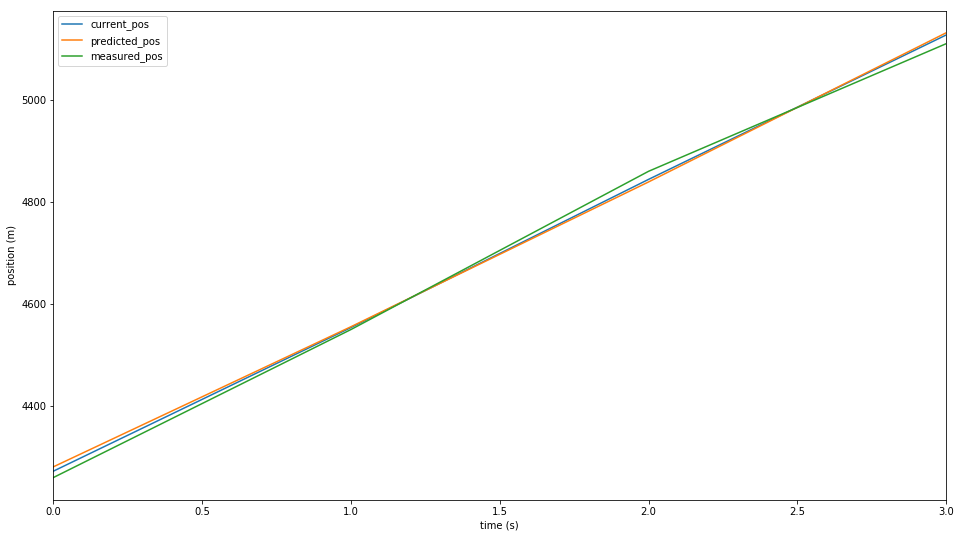

In [15]:
summary_pos=pd.DataFrame()
summary_pos['current_pos']=current_pos
summary_pos['predicted_pos']=predicted_pos
summary_pos['measured_pos']=a[1:]
summary_pos.plot.line(figsize=(16,9))
plt.xlabel('time (s)')
plt.ylabel('position (m)')